## Model Validation Samples

#### Contents:

* **EDA - Краткий обзор данных**
    - Графики распределения времени совершения транзакции в разрезе обучающей и тестовой выборок
    - Scatter-plot зависимости суммы транзакции от времени совершения транзакции
    - Графики зависимости даты транзакции в разрезе целевой переменной для обучающей и тестовой выборки
    - Распределение объемов транзакций (TransactionAmt) в логарифмическом масштабе
    - Распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6
    - Оценка пропусков
* **Hold-Out Validation (с разбиением на 2 выборки)**
    - xgb-model с подбором числа деревьев по early_stopping
* **Hold-Out Validation (с разбиением на 3 выборки)**
    - xgb-model с подбором числа деревьев по early_stopping
* **Доверительный интервал на основе BootStrap выборок**
    - Оценка доверительного интервала по Hold-Out Validation (с разбиением на 3 выборки)
* **Adversarial Validation**
    - Анализ гипотезы на train.csv / train + test.csv
* **KFold Validation**
    - Кросс-валидация на cross_val_score из пакета sklearn
    - KFold кросс-валидация на 5 фолдах. Общая оценка качества и разброса по метрике качества
    - KFold Validation по TimeSeriesSplit
* **Summaries**

In [1]:
##############
# Import libs
##############

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, TimeSeriesSplit
import xgboost as xgb
import catboost as catb
from typing import List, Tuple
import scipy.stats as st
import missingno as msno

In [2]:
############
# Data load
############


TRAIN_DATA_PATH = 'data/assignment_train.csv'
TEST_DATA_PATH = 'data/assignment_test.csv'


train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [4]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


In [5]:
test.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,7.500000e+04,75000.000000,7.500000e+04,75000.000000,75000.000000,74005.000000,75000.000000,74589.000000,64490.000000,64490.000000,...,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000
mean,3.099500e+06,0.025973,2.279529e+06,128.028591,9831.878667,371.307695,154.075347,199.892169,291.440564,86.974725,...,0.159060,105.575307,131.765079,119.110755,11.564440,21.261696,16.245663,36.206626,42.026613,38.234797
std,2.165078e+04,0.159057,4.140176e+05,193.315818,4908.219772,159.001973,12.295349,40.927724,100.732324,1.704298,...,0.764107,730.361658,854.615865,768.778641,102.634158,134.484367,119.260027,339.409687,378.479522,345.706813
min,3.062000e+06,0.000000,1.643492e+06,1.000000,1006.000000,100.000000,100.000000,100.000000,110.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.080750e+06,0.000000,1.950398e+06,45.000000,6019.000000,220.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.099500e+06,0.000000,2.187586e+06,75.000000,9633.000000,390.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.118249e+06,0.000000,2.595982e+06,131.000000,14223.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.136999e+06,1.000000,3.093408e+06,5094.950000,18396.000000,600.000000,231.000000,237.000000,536.000000,102.000000,...,15.000000,20750.000000,22500.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [7]:
### Settings

seed = 42
np.random.seed(seed)
discret_limit = 25

ID = 'TransactionID'
DATE = 'TransactionDT'
TARGET = 'isFraud' # Target

CAT_FEATS = train.select_dtypes(include='object').columns  # Categorical
ALL_NUMERICAL_FEATS = train.select_dtypes(include=[np.number]).columns # Numerical + Target
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop([TARGET, ID, DATE]) # Numerical only

# Discrete feature among numerical
DISCRETE_FEATS = [feature for feature in NUMERICAL_FEATS if len(train[feature].unique()) < discret_limit]

print(f"Categorical Features Count: {len(CAT_FEATS)}")
print(f"Numerical Features Count: {len(NUMERICAL_FEATS)}")
print(f"Discrete Features of Numerical Count: {len(DISCRETE_FEATS)}")
print(f"\nTotal Features: {len(train.columns)-1}")

Categorical Features Count: 14
Numerical Features Count: 377
Discrete Features of Numerical Count: 219

Total Features: 393


## EDA (short) 

##### Графики распределения времени совершения транзакции в разрезе обучающей и тестовой выборок

`TransactionDT` - кодированная временная метка. Для сравнения train с test используем распределение количества записей по времени

Тренеровочные и тестовые данные разделены по времени на два отрезка. В распределении прослеживается цикличность со сходной шириной периода. 

Датасет относится к timeseries, разбивку на сплиты следует проводить на части без шафла.
Локальные спады могут быть следствием сезонности, либо некачественного сбора данных, для выявления этой сезонности данных недостаточно.

Для построения модели можно потестировать техники работы с временными рядами: сглаживание с небольшими шагами, Arima-анализ, NN с LSTM-ячейками памяти

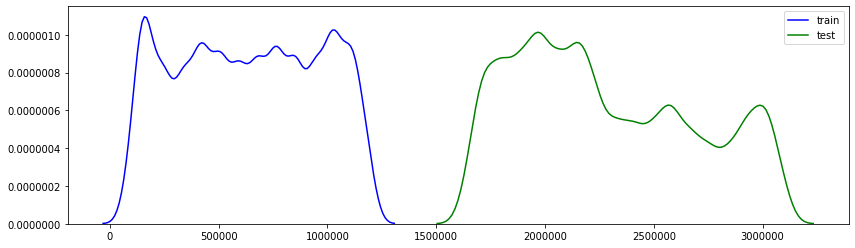

In [273]:
fig = plt.figure(figsize=(14,4))

sns.kdeplot(train[date_field], color="blue", label="train")
sns.kdeplot(test[date_field], color="green", label="test")
plt.show()

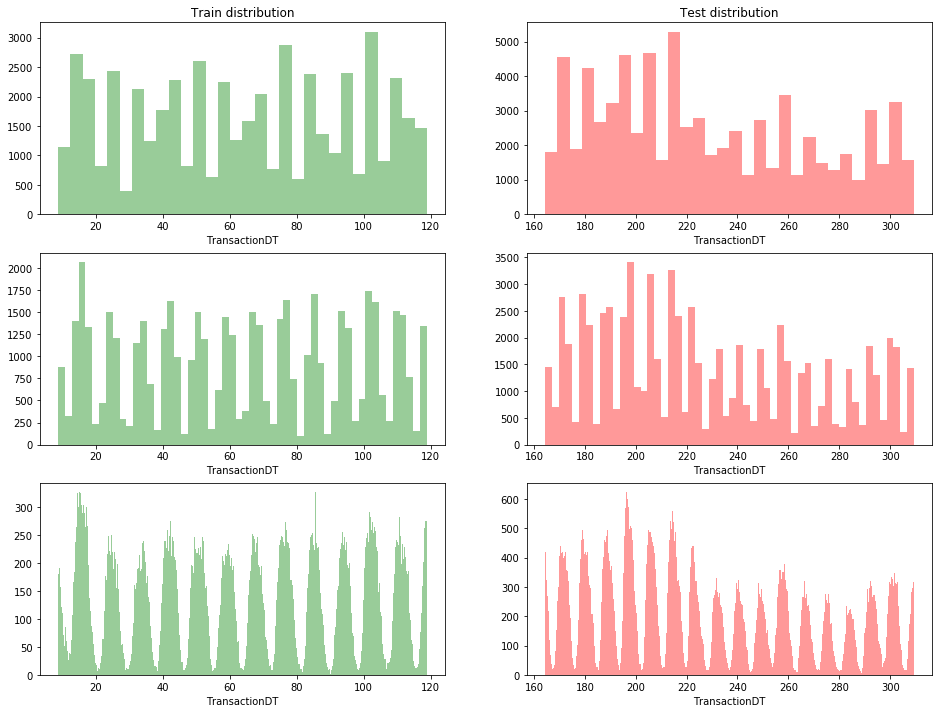

In [74]:
bins_list = [30, 54, 365]
n_charts = len(bins_list)

# scale values
tmp_train = train[DATE].copy()
tmp_test = test[DATE].copy()
tmp_train, tmp_test = tmp_train / 1e4, tmp_test / 1e4

fig, ax = plt.subplots(n_charts, 2, figsize=(16, n_charts*4))

for num, n_bins in enumerate(bins_list):
    
    sns.distplot(tmp_train, bins=n_bins, kde=False, color='green', ax=ax[num%n_charts, 0])

    sns.distplot(tmp_test, bins=n_bins, kde=False, color='red', ax=ax[num%n_charts, 1])
    
ax[0, 1].set_title('Test distribution')
ax[0, 0].set_title('Train distribution')   
plt.show()


##### Scatter-plot зависимости суммы транзакции от времени совершения транзакции

`Fraud`-транзакции в большинстве случаев проводятся по операциям малых объемов `TransactionAmt`. Модель легко запомнит этот паттерн и будет больше ошибаться на fraud с высоким `TransactionAmt`

In [314]:
# Assign focused features

date_field = 'TransactionDT'
value_field = 'TransactionAmt'

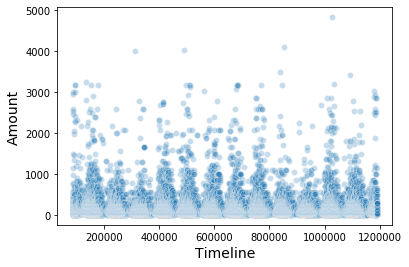

In [321]:
sns.scatterplot(x=train[date_field], y=train[value_field], alpha=0.25)
plt.ylabel("Amount", size=14)
plt.xlabel("Timeline", size=14)
plt.show()

##### Графики зависимости даты транзакции в разрезе целевой переменной для обучающей и тестовой выборки

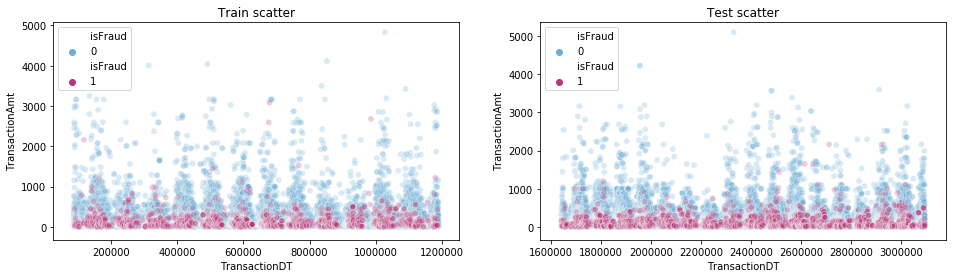

In [328]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

t0 = train.loc[train[TARGET]==0]
t1 = train.loc[train[TARGET]==1]

v0 = test.loc[test[TARGET]==0]
v1 = test.loc[test[TARGET]==1]

sns.scatterplot(x=date_field, y=value_field, alpha=0.25, hue=TARGET, ax=ax[0], data=t0, palette="Blues_r")
sns.scatterplot(x=date_field, y=value_field, alpha=0.25, hue=TARGET, ax=ax[0], data=t1, palette="magma")
ax[0].set_title('Train scatter')

sns.scatterplot(x=date_field, y=value_field, alpha=0.25, hue=TARGET, ax=ax[1], data=v0, palette="Blues_r")
sns.scatterplot(x=date_field, y=value_field, alpha=0.25, hue=TARGET, ax=ax[1], data=v1, palette="magma")
ax[1].set_title('Test scatter')

plt.show()

##### Распределение объемов транзакций (TransactionAmt) в логарифмическом масштабе

Распределение по объемам транзакций `TransactionAmt` далеко от нормального. Несбалансированность данных отрицательно повлияет на качество модели

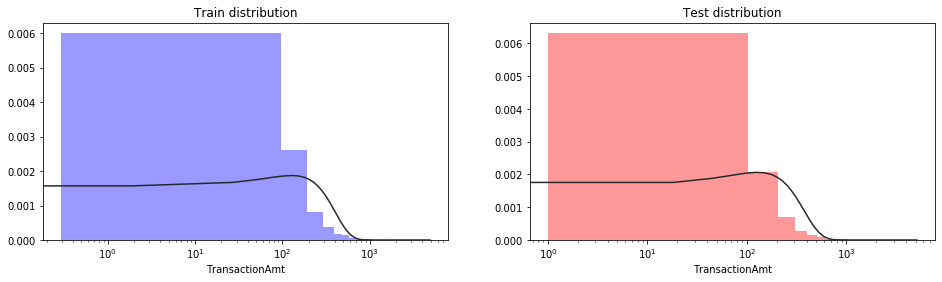

In [340]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(train[value_field], kde=False, color="blue", fit=st.norm, ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_title('Train distribution')

sns.distplot(test[value_field], kde=False, color="red", fit=st.norm, ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_title('Test distribution')

plt.show()

##### Распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6

Графики показывают значительный дисбаланс

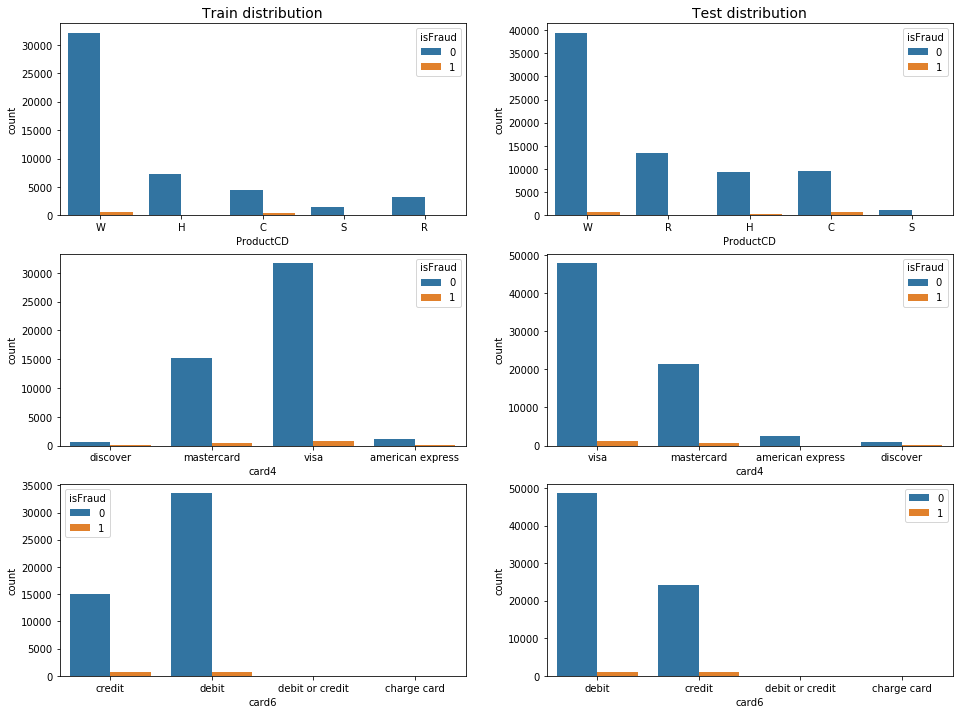

In [132]:
feats = ['ProductCD', 'card4', 'card6']
n_charts = len(feats)

fig, ax = plt.subplots(n_charts, 2, figsize=(16, len(feats)*4))

for num, feature in enumerate(feats):
    sns.countplot(x=feature, hue=TARGET, data=train, ax=ax[num%n_charts, 0])
    sns.countplot(x=feature, hue=TARGET, data=test, ax=ax[num%n_charts, 1])
    
ax[0, 0].set_title("Train distribution", fontsize=14)
ax[0, 1].set_title("Test distribution", fontsize=14)
plt.legend(loc='upper right')
plt.show()

### Оценка пропусков

В данных присутствуют категории со значительным числом **пропусков**, как в `train`, так и в `test` выборках

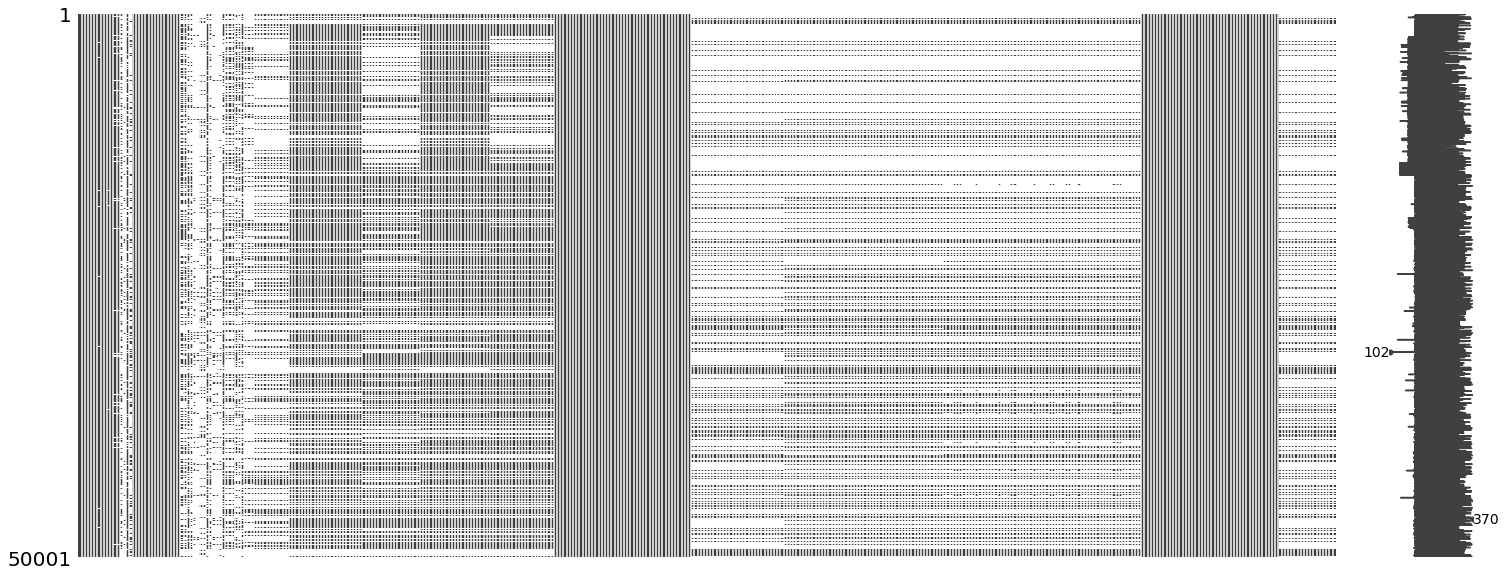

In [275]:
# NaN showplot
msno.matrix(train);

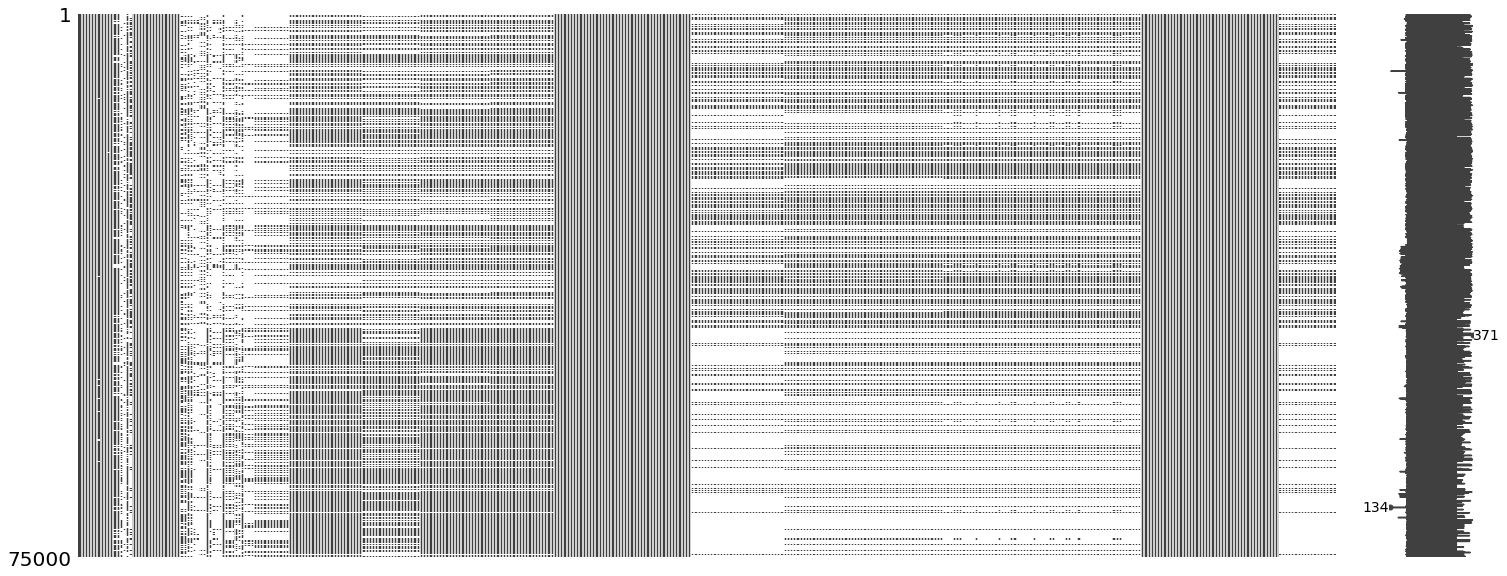

In [276]:
# NaN showplot
msno.matrix(test);

## Hold-Out Validation (с разбиением на 2 выборки)

In [137]:
# Hold-out Validation
X = train[NUMERICAL_FEATS]
y = train[TARGET]

# LB Validation
X_val = test[NUMERICAL_FEATS]
y_val = test[TARGET]


# Split train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print("x_train.shape = {} rows, {} cols".format(*X_train.shape))
print("x_test.shape = {} rows, {} cols".format(*X_test.shape))
print("x_LB.shape = {} rows, {} cols".format(*X_val.shape))

x_train.shape = 35000 rows, 377 cols
x_test.shape = 15001 rows, 377 cols
x_LB.shape = 75000 rows, 377 cols


In [138]:
# Проверка корректности разбиения по полю ID. Уникальные значения не пересекаются

# set(X_train[ID].unique()) & set(X_test[ID].unique())

In [139]:
# Train on splitted dataset

model = xgb.XGBClassifier(random_state=seed, n_jobs=4)

model.fit(X_train,
          y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.75808
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.76966
[2]	validation_0-auc:0.80165
[3]	validation_0-auc:0.80036
[4]	validation_0-auc:0.80377
[5]	validation_0-auc:0.81195
[6]	validation_0-auc:0.83429
[7]	validation_0-auc:0.84293
[8]	validation_0-auc:0.85515
[9]	validation_0-auc:0.86074
[10]	validation_0-auc:0.86489
[11]	validation_0-auc:0.86952
[12]	validation_0-auc:0.87671
[13]	validation_0-auc:0.87763
[14]	validation_0-auc:0.87790
[15]	validation_0-auc:0.87940
[16]	validation_0-auc:0.88120
[17]	validation_0-auc:0.88151
[18]	validation_0-auc:0.88416
[19]	validation_0-auc:0.88304
[20]	validation_0-auc:0.88320
[21]	validation_0-auc:0.88353
[22]	validation_0-auc:0.88384
[23]	validation_0-auc:0.88223
Stopping. Best iteration:
[18]	validation_0-auc:0.88416



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
train_score = roc_auc_score(y_train, model.predict(X_train))
test_score = roc_auc_score(y_test, model.predict(X_test))
val_score = roc_auc_score(y_val, model.predict(X_val))

print(f"Hold-Out Train splitted validation")
print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, ** LB-score: {round(val_score, 3)}")

Hold-Out Train splitted validation
Train-score: 0.739, Test-score: 0.664, ** LB-score: 0.636


Train-score: 0.739, Test-score: 0.664 - В данном случае классификатор значительно переобучился
Переподгонка ещё сильнее проявляется на новых данных (test датасете)

## Hold-Out Validation (с разбиением на 3 выборки)

In [66]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=seed)


print("x_train.shape = {} rows, {} cols".format(*X_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*X_val.shape))
print("x_test.shape = {} rows, {} cols".format(*X_test.shape))

x_train.shape = 35000 rows, 377 cols
x_valid.shape = 10500 rows, 377 cols
x_test.shape = 4501 rows, 377 cols


In [67]:
model = xgb.XGBClassifier(random_state=seed, n_jobs=4)
model.fit(X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.75405
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.76492
[2]	validation_0-auc:0.79593
[3]	validation_0-auc:0.79466
[4]	validation_0-auc:0.79856
[5]	validation_0-auc:0.80666
[6]	validation_0-auc:0.82924
[7]	validation_0-auc:0.84027
[8]	validation_0-auc:0.85229
[9]	validation_0-auc:0.85541
[10]	validation_0-auc:0.86053
[11]	validation_0-auc:0.86334
[12]	validation_0-auc:0.87031
[13]	validation_0-auc:0.87017
[14]	validation_0-auc:0.87128
[15]	validation_0-auc:0.87143
[16]	validation_0-auc:0.87384
[17]	validation_0-auc:0.87433
[18]	validation_0-auc:0.87714
[19]	validation_0-auc:0.87577
[20]	validation_0-auc:0.87553
[21]	validation_0-auc:0.87551
[22]	validation_0-auc:0.87692
[23]	validation_0-auc:0.87505
Stopping. Best iteration:
[18]	validation_0-auc:0.87714



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
train_score = roc_auc_score(y_train, model.predict(X_train))
valid_score = roc_auc_score(y_val, model.predict(X_val))
test_score = roc_auc_score(y_test, model.predict(X_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.739, Valid-score: 0.662, Test-score: 0.666


Val и Test метрики достаточно близки друг к другу

## Доверительный интервал на основе BootStrap выборок

In [53]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [54]:
scores = create_bootstrap_metrics(y_test, model.predict(X_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.6704791689838954, 0.7509444835209104)

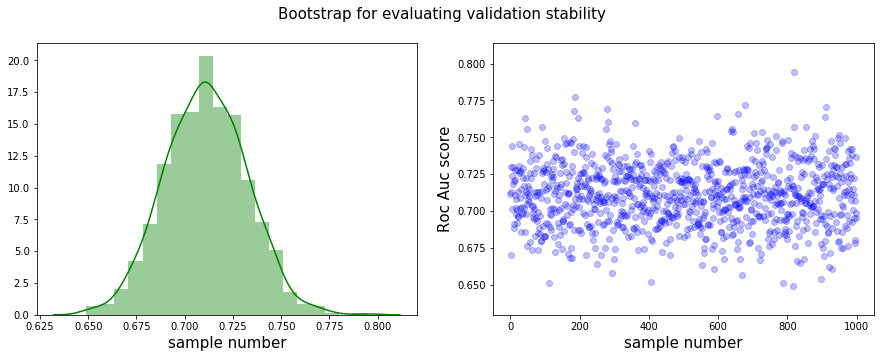

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("Roc Auc score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)
plt.show()

Доверительный интервал имеет диапазон в пределах от **0.67** до  **0.75** - разница в границах велика. **Метрика** качества модели на **тестовых** данных (0.66) **не входит в доверительный интервал**, что позволяет сделать вывод о **неудовлетворительном** качестве валидации

## Adversarial Validation

В Adversarial Validation используется гипотеза о том, что в train-данных могут находиться наблюдения, сильно похожие на тестовые. Для этого использован классификатор принадлежности данных к train / test датасету, с последующим использованием  в качестве валидационного датасета наиболее похожих данных

#### `train.csv` split evaluation:

В качестве теста посмотрим на похожие признаки внутри `train.csv` со **test_size=0.5** (изменение долей сплита смещает мат. ожидание предсказания вероятности модели)

In [215]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=seed)

X_adv = pd.concat([
    X_train, X_test], axis=0)
y_adv = np.hstack((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
assert X_adv.shape[0] == y_adv.shape[0]

In [216]:
model = xgb.XGBClassifier()
model.fit(X_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
y_pred = model.predict_proba(X_train)

In [218]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts()

(0.0, 0.1]       58
(0.1, 0.2]      486
(0.2, 0.3]     1436
(0.3, 0.4]     3700
(0.4, 0.5]    11477
(0.5, 0.6]     7558
(0.6, 0.7]      275
(0.7, 0.8]       10
(0.8, 0.9]        0
(0.9, 1.0]        0
dtype: int64

#### `train.csv` + `test.csv` split evaluation:

In [49]:
xtrain = train[NUMERICAL_FEATS].copy()
y_train = train[TARGET].copy()

X_adv = pd.concat([
    xtrain, xtest], axis=0)
y_adv = np.hstack((np.zeros(xtrain.shape[0]), np.ones(xtest.shape[0])))
assert X_adv.shape[0] == y_adv.shape[0]

In [50]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(X_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
y_pred = model.predict_proba(xtrain)

In [52]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts()

(0.0, 0.1]    14524
(0.1, 0.2]     1484
(0.2, 0.3]     1942
(0.3, 0.4]     2082
(0.4, 0.5]     3167
(0.5, 0.6]     9418
(0.6, 0.7]    11412
(0.7, 0.8]     3548
(0.8, 0.9]     1984
(0.9, 1.0]      440
dtype: int64

#### Используем наиболее похожие (с порогом > 0.7) xtrain метки в качестве валидационного датасета

In [53]:
threshold = 0.7

xtrain[TARGET] = y_train
xtrain['is_valid'] = np.where(y_pred[:, 1] > threshold, 1, 0) 

In [57]:
X_train =  xtrain.loc[xtrain['is_valid']==0][NUMERICAL_FEATS]
X_val = xtrain.loc[xtrain['is_valid']==1][NUMERICAL_FEATS]

y_train = xtrain.loc[xtrain['is_valid']==0][TARGET]
y_val = xtrain.loc[xtrain['is_valid']==1][TARGET]

X_test = test[NUMERICAL_FEATS]
y_test = test[TARGET]

print(f"Train split.shape: {X_train.shape[0]}, Val split.shape: {X_val.shape[0]}, Test split.shape: {X_test.shape[0]}")

Train split.shape: 44029, Val split.shape: 5972, Test split.shape: 75000


In [60]:
model = xgb.XGBClassifier(random_state=seed, n_jobs=4)

model.fit(X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.62911
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.78158
[2]	validation_0-auc:0.77470
[3]	validation_0-auc:0.79322
[4]	validation_0-auc:0.80333
[5]	validation_0-auc:0.80379
[6]	validation_0-auc:0.81597
[7]	validation_0-auc:0.81876
[8]	validation_0-auc:0.81039
[9]	validation_0-auc:0.80529
[10]	validation_0-auc:0.81208
[11]	validation_0-auc:0.81110
[12]	validation_0-auc:0.82403
[13]	validation_0-auc:0.82247
[14]	validation_0-auc:0.82449
[15]	validation_0-auc:0.82524
[16]	validation_0-auc:0.82117
[17]	validation_0-auc:0.83151
[18]	validation_0-auc:0.83411
[19]	validation_0-auc:0.83377
[20]	validation_0-auc:0.83466
[21]	validation_0-auc:0.84392
[22]	validation_0-auc:0.84800
[23]	validation_0-auc:0.85225
[24]	validation_0-auc:0.84938
[25]	validation_0-auc:0.85055
[26]	validation_0-auc:0.85226
[27]	validation_0-auc:0.85468
[28]	validation_0-auc:0.85144
[29]	validation_0-auc:0.85172
[30]	validation_0-auc:0.85241
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
train_score = roc_auc_score(y_train, model.predict(X_train))
valid_score = roc_auc_score(y_val, model.predict(X_val))
test_score = roc_auc_score(y_test, model.predict(X_test))

# Результат HO validation с разбиением на 3 выборки: Train-score: 0.739, Valid-score: 0.662, Test-score: 0.666
print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.776, Valid-score: 0.591, Test-score: 0.636


В данном случае Adversarial validation не привел к улучшению качества модели. По сравнением с качеством модели Hold-Out на тестовых данных осталось в пределах статистической погрешности

## KFold Validation

Базовая реализация через `cross_val_score()`

In [80]:
# X = train.drop([ID, TARGET], axis=1)
# X = X[NUMERICAL_FEATS]
# y = train[TARGET]

# sorted(sklearn.metrics.SCORERS.keys()) # metric scroring availabilities

cv = cross_val_score(
    estimator=model,
    X=X,
    y=y,
    scoring="roc_auc",
    cv=5
)

print(cv)
print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.864 +/- 0.029


In [84]:
print(cv)

[0.86010404 0.87904765 0.8969035  0.81145045 0.8726064 ]


Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [164]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

Качество метрики на фолдах показало стандартное отклонение в районе 2.2%, что в общем случае, достаточно велико и говорит о низкой консистентности модели, на новых данных качество может значительно варьироваться

In [83]:
cv_strategy = KFold(n_splits=5, random_state=None)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X=X, y=y, estimator=model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.7664, valid-score = 0.6366
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.7608, valid-score = 0.6175
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.7577, valid-score = 0.6719
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.7595, valid-score = 0.6421
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.7546, valid-score = 0.607
CV-results train: 0.7598 +/- 0.004
CV-results valid: 0.635 +/- 0.022
OOF-score = 0.6363


## KFold Validation по TimeSeriesSplit

В метриках валидации 10 фолдов с разбиенеием по TimeSeriesSplit проявляется характер распределения временных меток, которое характеризуется низкой плотностью в начале и конце периода. Результат выражен низким качеством метрики на 1-м разбиении и снижении качества к последнему (при тестировании на 5 фолдах функция метрики имела более гладкий вид без скачков скора). Также наблюдается снижение `train-score`, т.е. с увеличением выборки, снижается склонность к переобучению модели

In [160]:
# Test example
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [171]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

cv = TimeSeriesSplit(n_splits=10)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X=X, y=y, estimator=model, metric=roc_auc_score, cv_strategy=cv
)

Fold: 1, train-observations = 4551, valid-observations = 4545
train-score = 0.8368, valid-score = 0.5924
Fold: 2, train-observations = 9096, valid-observations = 4545
train-score = 0.8008, valid-score = 0.5545
Fold: 3, train-observations = 13641, valid-observations = 4545
train-score = 0.7745, valid-score = 0.6298
Fold: 4, train-observations = 18186, valid-observations = 4545
train-score = 0.751, valid-score = 0.6399
Fold: 5, train-observations = 22731, valid-observations = 4545
train-score = 0.7566, valid-score = 0.6416
Fold: 6, train-observations = 27276, valid-observations = 4545
train-score = 0.7433, valid-score = 0.679
Fold: 7, train-observations = 31821, valid-observations = 4545
train-score = 0.7453, valid-score = 0.661
Fold: 8, train-observations = 36366, valid-observations = 4545
train-score = 0.733, valid-score = 0.6106
Fold: 9, train-observations = 40911, valid-observations = 4545
train-score = 0.7379, valid-score = 0.6835
Fold: 10, train-observations = 45456, valid-observat

## Summaries

- Проведен выборочный EDA анализ 
- Были протестированы различные методы валидации выборки

#### EDA:
- Тренеровочные и тестовые данные разделены по времени на два отрезка. В распределении прослеживается цикличность со сходной шириной периода

- Датасет относится к timeseries, разбивку на сплиты следует проводить на части без шафла. Локальные спады могут быть следствием сезонности, либо некачественного сбора данных, для выявления этой сезонности данных недостаточно.

- Для построения модели можно потестировать техники работы с временными рядами: сглаживание с небольшими шагами, Arima-анализ, NN с LSTM-ячейками памяти

- `Fraud`-транзакции в большинстве случаев проводятся по операциям малых объемов `TransactionAmt`. Модель легко запомнит этот паттерн и будет больше ошибаться на fraud с высоким `TransactionAmt`

- Распределение по объемам транзакций `TransactionAmt` в логарифмическом масштабе далеко от нормального. Несбалансированность данных отрицательно повлияет на качество модели

- Распределение признака целевой переменной `isFraud` в зависимости от значений категориальных признаков `ProductCD`, `card4`, `card6` показывает серьёзную несбалансированность меток

- В данных присутствуют категории со значительным числом пропусков, как в train, так и в test выборках. Хорошая модель **требует обработки пропусков**

#### Validation

- **Hold-Out Validation на 2-х выборках**: (Train-score: **0.739**, Test-score: **0.664**) - В данном случае классификатор переобучился. Переподгонка сильнее проявляется на `test` датасете

- **Hold-Out Validation на 3-х выборках**: (Train-score: **0.739**, Valid-score: **0.662**, Test-score: **0.666**). Val и Test метрики показывают близость друг к другу. Модель *выглядит консистентной*

- Построение **доверительного интервала на основе BootStrap** выборок имеет диапазон в пределах от **0.67** до **0.75** - разница в границах велика. Метрика качества модели на тестовых данных (**0.66**) не входит в доверительный интервал, что позволяет сделать вывод о неудовлетворительном качестве валидации

- Оценка модели по **Adversarial Validation** не привела к улучшению качества модели. По сравнением с качеством модели Hold-Out на тестовых данных осталось в пределах статистической погрешности

- **KFold Validation** на 5 фолдов показало стандартное отклонение в районе **2.2%**. Результаты валидации имеют разброс порядка **7%**, что достаточно велико, и говорит о низкой консистентности модели. На новых данных качество может варьироваться в оцененных пределах.

- **KFold Validation по TimeSeriesSplit** на 10 фолдах (справедливо для 5 фолдов) с разбиенеием по TimeSeriesSplit проявляется характер распределения временных меток, которое характеризуется низкой плотностью в начале и конце периода. Результат выражен низким качеством метрики на 1-ых разбиениях и снижении ближе к последнему (при тестировании на 5 фолдах функция метрики имела более гладкий вид без скачков скора). Также наблюдается снижение `train-score`, т.е. с увеличением выборки, снижается склонность к переобучению модели

Валидация позволяет получить уверенность в стабильности модели. На текущем датасете улучшение метрики можно достигнуть за счет **Feature Engineering**, подбора и **настройки параметров** модели.